In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT
###!@0 END INIT ENVIRONMENT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Common Imports
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as f
import pandas as pd
from pyspark.sql.functions import regexp_replace

In [ ]:
#%cd /content/drive/Shareddrives/DataEngineeringProject/
%reload_ext autoreload
%autoreload 2
from SyntheticDataGeneration import *
from QuerySet1 import *
from QuerySet2 import *

/content/drive/Shareddrives/DataEngineeringProject


In [ ]:
#Constant paths, variables, etc
years = ["2017_2018", "2018_2019", "2019_2020"]
SouthStates = ["AndhraPradesh", "Karnataka", "Kerala", "TamilNadu", "Telangana"]
#basePath = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/"
basePath = "SouthDistricts/"
"""
  Method to read the data for a particular state on particular time period (current default : 2019_2020)
  Drops all the unnecessary columns and replaces nulls with 0 and returns the data
"""
def readAllDataForState(state, year="2019_2020"):
  path = basePath + year + "/" + state + "/*.csv"
  data = spark.read.option("header",True).option("inferSchema",True).csv(path)
  colsNotRequired = ("Building", "Boundary_Wall", "Single_Class_Room",\
                     "Separate_Room_for_Headmaster", "Land_Available", "Electricity",\
                      "Furniture", "Librarian", "Boy_Toilet", "Girl_Toilet", "Drinking_Water")
  data.drop(*colsNotRequired)
  data.na.fill(0)
  return data

**Q1 : Comprehensive analysis of Rural and Urban school distribution  - week3**

a. Obtain State wise distribution i.e., State(X, Y) [X: Urban, Y: Rural] and Find the state with highest Ratio

b. Get Top 10 districts with highest number of schools in rural area

c. Classification of schools based on type of school management in urban and rural areas and list top 10 districts with highest number of private schools in rural area

Q1: a. Obtain State wise distribution i.e., State(X, Y) [X: Urban, Y: Rural] and Find the state with highest Ratio

2017_2018 :  {'Telangana': 0.4044473352575308, 'Karnataka': 0.39284846521422206, 'TamilNadu': 0.33795533589602783, 'AndhraPradesh': 0.2614832583311857, 'Kerala': 0.2558566069195498}
2018_2019 :  {'Telangana': 0.3725979951377094, 'Karnataka': 0.3579091323507066, 'TamilNadu': 0.34347816212042065, 'Kerala': 0.2552689397021727, 'AndhraPradesh': 0.24972499410701657}
2019_2020 :  {'Telangana': 0.45221708225205914, 'Karnataka': 0.39097988319273197, 'TamilNadu': 0.3654384830855419, 'AndhraPradesh': 0.2550438510245015, 'Kerala': 0.2505628095452499}


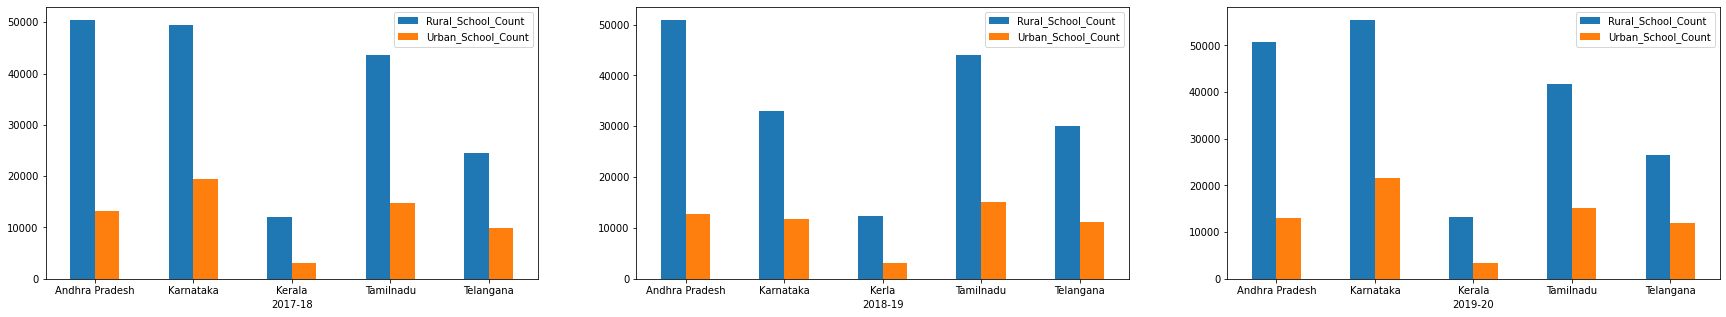

In [ ]:
#3m55s
fig1, axes1 = plt.subplots(1, 3, figsize=(30,5))
ans = {}
index = 0
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)
  ans[year], result = state_urban_rural_school_dist(SouthStates, data, axes1, index)
  print(year, ": ", ans[year])
  index += 1

Q1: b. Get Top 10 districts with highest number of schools in rural area

In [ ]:
#8s
data = {}
for state in SouthStates:
  data[state] = readAllDataForState(state)
answer1, answer2 = districts_highest_rural_schools(SouthStates, data)
print(answer1)

[('CHITTOOR', 5248), ('EAST GODAVARI', 5202), ('VISAKHAPATNAM', 4162), ('ANANTAPUR', 4121), ('WEST GODAVARI', 3860), ('PRAKASAM', 3846), ('GUNTUR', 3699), ('SRIKAKULAM', 3627), ('NELLORE', 3622), ('KRISHNA', 3565)]


Q1: c. list top 10 districts with highest number of private schools in rural area and show classification of schools based on type of school management in urban and rural areas

[('EAST GODAVARI', 1154), ('KRISHNA', 848), ('WEST GODAVARI', 836), ('KURNOOL', 724), ('VIJAYAPURA', 691), ('CHITTOOR', 688), ('ANANTAPUR', 648), ('GUNTUR', 593), ('PRAKASAM', 588), ('KALBURGI', 581)]


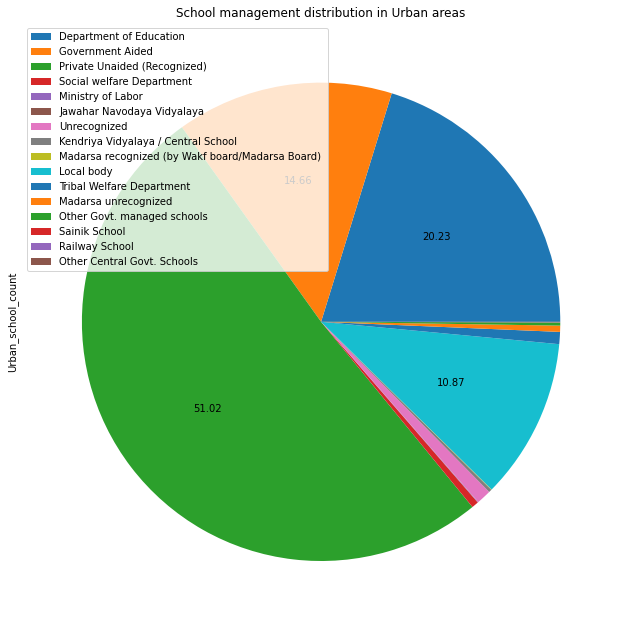

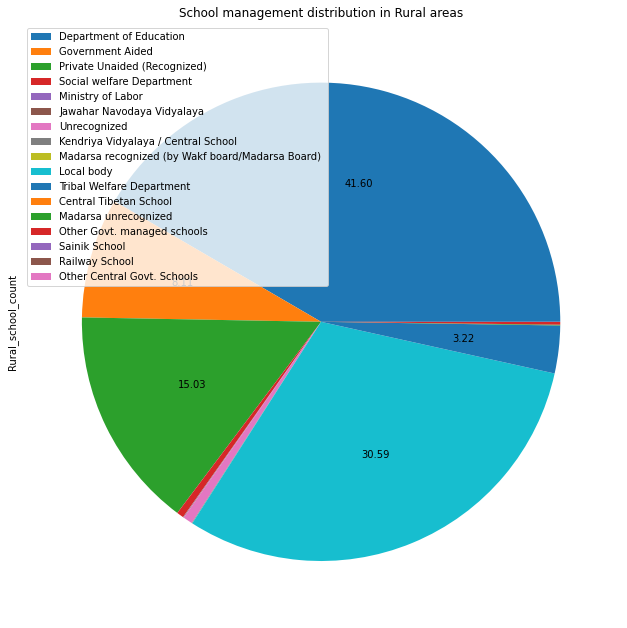

In [ ]:
#33s
data = {}
for state in SouthStates:
  data[state] = readAllDataForState(state)

answer1, answer2 = district_urban_rural_category_school_dist(SouthStates, data)
print(answer1)
classification_school_management(SouthStates, data)

**Q2 : Investigating availability of Essential, Advanced Facilities**

a. How many schools have facilities for specially abled children, rank the states accordingly ?

b. Give the percentage of schools per state which provide essential facilities(only functional) like drinking water, toilet-girls/boys, hand-wash, electricity, newspaper, library, playground.

c. Give the percentage of schools per state which provide advanced facilities like internet, computer.

Q2. a. How many schools have facilities for specially abled children, rank the states accordingly ?

2017_2018 :  [('Tamilnadu', 70), ('Kerala', 63), ('Karnataka', 48), ('Andhra Pradesh', 32), ('Telangana', 32)]
2018_2019 :  [('Kerla', 67), ('Tamilnadu', 62), ('Karnataka', 49), ('Telangana', 38), ('Andhra Pradesh', 37)]
2019_2020 :  [('Telangana', 86), ('Tamilnadu', 73), ('Kerala', 69), ('Karnataka', 49), ('Andhra Pradesh', 42)]


Text(0, 0.5, 'Specially Abled Support')

<Figure size 1440x360 with 0 Axes>

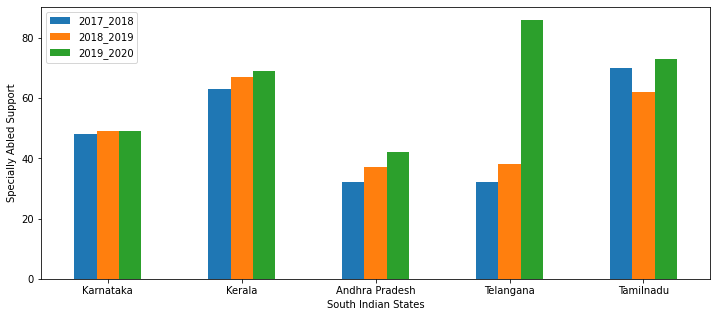

In [ ]:
#23s
fig1, axes1 = plt.subplots(0, 3, figsize=(20,5))

index = 0
ans = {}
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)

  allStatesData = [data[state] for state in SouthStates]
  allStatesData = unionAll(*allStatesData)
  ans[year], q1ADict = specially_abled_ranking(SouthStates, allStatesData)
  index += 1

allYearsData = []
for year in years:
  currentYearData = ans[year]
  final = []
  for i in currentYearData.collect():
    final.append(tuple(i))
  print(year, ": ", final)
  currentYearData = currentYearData.withColumnRenamed("RampVsSchoolRatio", year).\
  withColumn("State_Name", regexp_replace('State_Name', 'Kerla', 'Kerala'))
  allYearsData.append(currentYearData)
temporalData = allYearsData[0].join(allYearsData[1], ["State_Name"]).join(allYearsData[2], ["State_Name"])
temporalDataPlot = temporalData.toPandas()
temporalDataPlot["2017_2018"]=pd.to_numeric(temporalDataPlot["2017_2018"])
temporalDataPlot["2018_2019"]=pd.to_numeric(temporalDataPlot["2018_2019"])
temporalDataPlot["2019_2020"]=pd.to_numeric(temporalDataPlot["2019_2020"])
ax = temporalDataPlot.plot.bar(x="State_Name", figsize=(12,5), rot=0)
ax.set_xlabel("South Indian States")
ax.set_ylabel("Specially Abled Support")


Q2. b. Give the percentage of schools per state which provide essential facilities(only functional) like drinking water, toilet-girls/boys, hand-wash, electricity, newspaper, library, playground.

In [ ]:
#22s
data = {}
dfs = []
for state in SouthStates:
  data[state] = readAllDataForState(state, year)
  q2B, b = essentials_schoolper_state(SouthStates, data[state])
  dfs.append(q2B)
ans = unionAll(*dfs)
ans.show() 

+--------------+-------------------------+---------------------+----------------------+--------+----------------------+--------------------+--------------------------------------+----------+
|    State_Name|Functional_Drinking_Water|Functional_Boy_Toilet|Functional_Girl_Toilet|Handwash|Functional_Electricity|Functional_Newspaper|Library_or_Reading_Corner_or_Book_Bank|Playground|
+--------------+-------------------------+---------------------+----------------------+--------+----------------------+--------------------+--------------------------------------+----------+
|Andhra Pradesh|                       89|                   61|                    70|      84|                    95|                  42|                                    89|        68|
|     Karnataka|                       94|                   96|                    98|      81|                    97|                  67|                                    92|        77|
|        Kerala|                       99|   

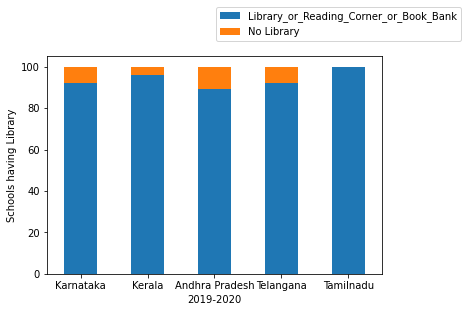

In [ ]:
#8s
dfs = []
for state in SouthStates:
  dfs.append(readAllDataForState(state, year))
data = unionAll(*dfs)
plot_LibraryAvailability(SouthStates, data)

Q2. c. Give the percentage of schools per state which provide advanced facilities like internet, computer.

2017_2018 :  [('Karnataka', 8, 41), ('Kerala', 64, 96), ('Andhra Pradesh', 11, 33), ('Telangana', 18, 38), ('Tamilnadu', 28, 58)]
2018_2019 :  [('Karnataka', 11, 92), ('Kerla', 87, 87), ('Andhra Pradesh', 17, 28), ('Telangana', 18, 33), ('Tamilnadu', 23, 50)]
2019_2020 :  [('Karnataka', 24, 48), ('Kerala', 87, 93), ('Andhra Pradesh', 22, 36), ('Telangana', 19, 34), ('Tamilnadu', 32, 78)]


Text(0, 0.5, 'Advanced facilities')

<Figure size 1440x360 with 0 Axes>

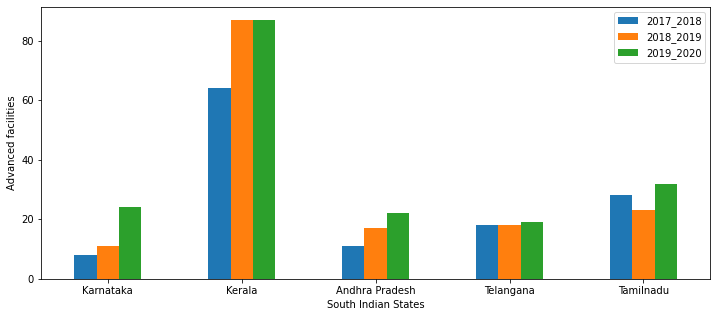

In [ ]:
#21s
fig1, axes1 = plt.subplots(0, 3, figsize=(20,5))

index = 0
ans = {}
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)

  allStatesData = [data[state] for state in SouthStates]
  allStatesData = unionAll(*allStatesData)
  ans[year], q1ADict = advFacilities_schoolper_state(SouthStates, allStatesData)
  index += 1

allYearsData = []
for year in years:
  currentYearData = ans[year]
  final = []
  for i in currentYearData.collect():
    final.append(tuple(i))
  print(year, ": ", final)
  currentYearData = currentYearData.drop('Computer_Available')
  currentYearData = currentYearData.withColumnRenamed("Internet", year).\
  withColumn("State_Name", regexp_replace('State_Name', 'Kerla', 'Kerala'))
  allYearsData.append(currentYearData)
temporalData = allYearsData[0].join(allYearsData[1], ["State_Name"]).join(allYearsData[2], ["State_Name"])
temporalDataPlot = temporalData.toPandas()
temporalDataPlot["2017_2018"]=pd.to_numeric(temporalDataPlot["2017_2018"])
temporalDataPlot["2018_2019"]=pd.to_numeric(temporalDataPlot["2018_2019"])
temporalDataPlot["2019_2020"]=pd.to_numeric(temporalDataPlot["2019_2020"])
ax = temporalDataPlot.plot.bar(x="State_Name", figsize=(12,5), rot=0)
ax.set_xlabel("South Indian States")
ax.set_ylabel("Advanced facilities")

**Q3 : Analysis of Hygiene level of schools**

a. Build hygiene score based on availability of water purifiers, tested water, drinking water, functional toilet, functional urinals and hand-wash for each district across states and list top 10 districts with highest Hygiene score 

b. Calculate the global mean of hygiene score and list the districts exceeding the mean for each state

c. Plot a graph of hygiene score for each state showing the distribution

2017_2018: a) [('Tamilnadu', 'ERODE', Decimal('86.35540357101440000')), ('Tamilnadu', 'SALEM', Decimal('82.25313482281910000')), ('Tamilnadu', 'KRISHANAGIRI', Decimal('82.18373633941240000')), ('Tamilnadu', 'COIMBATORE', Decimal('81.98489621360630000')), ('Tamilnadu', 'THE NILGIRIS', Decimal('79.79714898677430000')), ('Tamilnadu', 'PUDUKKOTTAI', Decimal('78.87809589807200000')), ('Tamilnadu', 'CUDDALORE', Decimal('78.81804138003930000')), ('Tamilnadu', 'THENI', Decimal('78.74391075269250000')), ('Tamilnadu', 'TIRUVANNAMALAI', Decimal('77.70272607590280000')), ('Tamilnadu', 'SIVAGANGA', Decimal('77.22549251602940000'))]
2018_2019: a) [('Kerla', 'THRISSUR', Decimal('90.53670697105320000')), ('Karnataka', 'UDUPI', Decimal('89.89619915711890000')), ('Tamilnadu', 'ERODE', Decimal('89.41378302871710000')), ('Tamilnadu', 'TIRUPPUR', Decimal('88.32116707878560000')), ('Tamilnadu', 'THE NILGIRIS', Decimal('88.30352395185070000')), ('Karnataka', 'DAKSHINA KANNADA', Decimal('88.05223840964400000'

Text(0, 0.5, 'Hygiene Score')

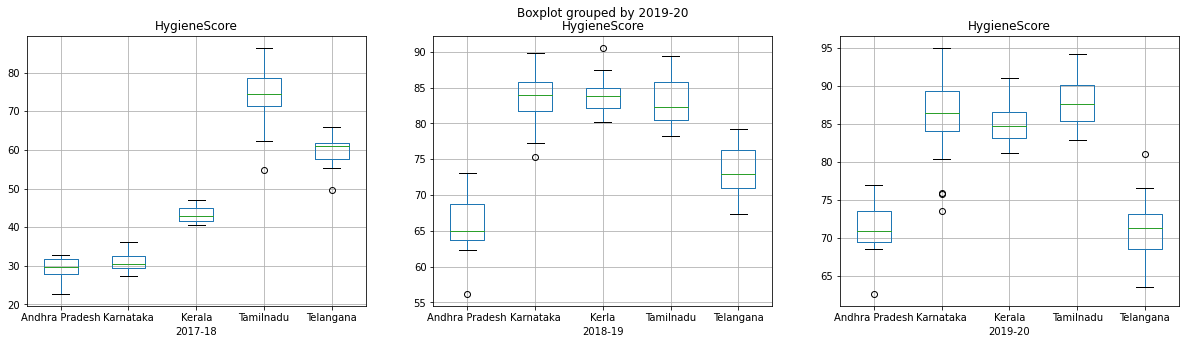

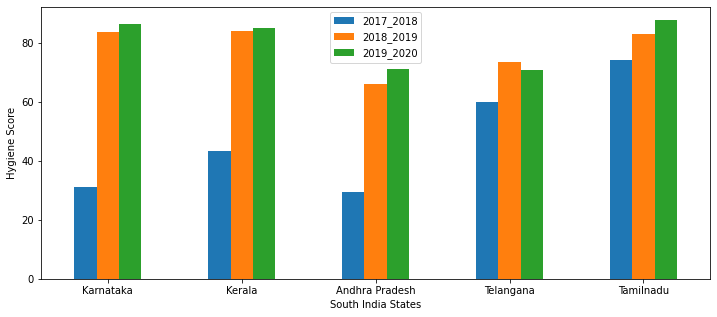

In [ ]:
#3m6s
#execution time 3min
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
fig1, axes1 = plt.subplots(1, 3, figsize=(20,5))

index = 0
ans = {}
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)
  ans[year] = buildHygieneScoreGetTop10(SouthStates, data, axes1, index)
  index += 1
for year in years:
  print(year + ": a) " + str(ans[year][0]))

for year in years:
  print(year + ": b) " + str(ans[year][1]))

allYearsData = []
for year in years:
  currentYearData = ans[year][3]
  currentYearData = currentYearData.withColumnRenamed("HygieneScoreVal", year).\
  withColumn("State_Name", regexp_replace('State_Name', 'Kerla', 'Kerala'))
  allYearsData.append(currentYearData)
temporalData = allYearsData[0].join(allYearsData[1], ["State_Name"]).join(allYearsData[2], ["State_Name"])
temporalDataPlot = temporalData.toPandas()
temporalDataPlot["2017_2018"]=pd.to_numeric(temporalDataPlot["2017_2018"])
temporalDataPlot["2018_2019"]=pd.to_numeric(temporalDataPlot["2018_2019"])
temporalDataPlot["2019_2020"]=pd.to_numeric(temporalDataPlot["2019_2020"])
ax = temporalDataPlot.plot.bar(x="State_Name", figsize=(12,5), rot=0)
ax.set_xlabel("South India States")
ax.set_ylabel("Hygiene Score")

**Q4 : Analysis of self sustainability of schools**

a. Calculate Self sustainability score for schools of each district based on Rain water harvesting, Solar panel, Kitchen garden, incinerator availability and list top 10 districts of all states based on highest sustainability score.

b. Investigate the sustainability among private and government schools for all states

c. Plot a state-wise graph to compare the self sustainability of each state

Q4. a. Calculate Self sustainability score for schools of each district based on Rain water harvesting, Solar panel, Kitchen garden, incinerator availability and list top 10 districts of all states based on highest sustainability score.

2017_2018 :  [('SALEM', 39.9031996988522), ('ERODE', 38.09986177275507), ('CHENNAI', 37.91111158423323), ('NAMAKKAL', 37.574671525703785), ('KARUR', 37.39895797218426), ('SIVAGANGA', 36.80862227100219), ('KANNIYAKUMARI', 35.99407525363782), ('DHARMAPURI', 35.92483971401155), ('THIRUVARUR', 35.37926326068827), ('TIRUVANNAMALAI', 35.341002404073365)]
2018_2019 :  [('UDUPI', 59.729139534250045), ('CHIKKABALLAPURA', 59.47642893541884), ('MYSURU', 59.085643746709415), ('DAKSHINA KANNADA', 57.87509758638071), ('KOLAR', 57.46058195492728), ('TUMAKURU', 57.13606097502837), ('BENGALURU RURAL', 57.06650548233243), ('MANDYA', 56.42265192250312), ('UTTARA KANNADA SIRSI', 55.842278580056515), ('DAVANAGERE', 55.67016982188267)]
2019_2020 :  [('UDUPI', 53.27408699212756), ('SALEM', 51.270237484468225), ('DHARMAPURI', 50.496556971587836), ('ERODE', 50.319305542181056), ('NAMAKKAL', 50.21523862727829), ('KODAGU', 49.77846157925844), ('COIMBATORE', 49.53797801626543), ('TIRUPPUR', 49.49110374235804), ('

Text(0, 0.5, 'Sustainability Score')

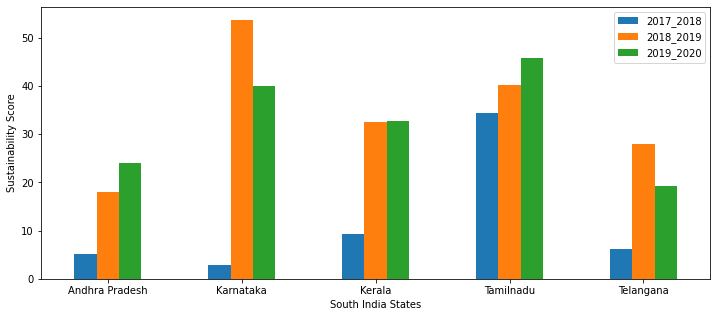

In [ ]:
#1m16s
ans = {}
index = 0
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)
  ans[year] = self_sustain_scoreQ1(SouthStates, data)
  print(year, ": ", ans[year][0])
  index += 1

allYearsData = []
for year in years:
  currentYearData = ans[year][2]
  currentYearData = currentYearData.withColumnRenamed("Sustainability_score", year).\
  withColumn("State_Name", regexp_replace('State_Name', 'Kerla', 'Kerala'))
  allYearsData.append(currentYearData)
temporalData = allYearsData[0].join(allYearsData[1], ["State_Name"]).join(allYearsData[2], ["State_Name"])
temporalDataPlot = temporalData.toPandas()
temporalDataPlot["2017_2018"]=pd.to_numeric(temporalDataPlot["2017_2018"])
temporalDataPlot["2018_2019"]=pd.to_numeric(temporalDataPlot["2018_2019"])
temporalDataPlot["2019_2020"]=pd.to_numeric(temporalDataPlot["2019_2020"])
ax = temporalDataPlot.plot.bar(x="State_Name", figsize=(12,5), rot=0)
ax.set_xlabel("South India States")
ax.set_ylabel("Sustainability Score")

Q4. b. Investigate the sustainability among private and government schools for all states
c. Plot a state-wise graph to compare the self sustainability of each state

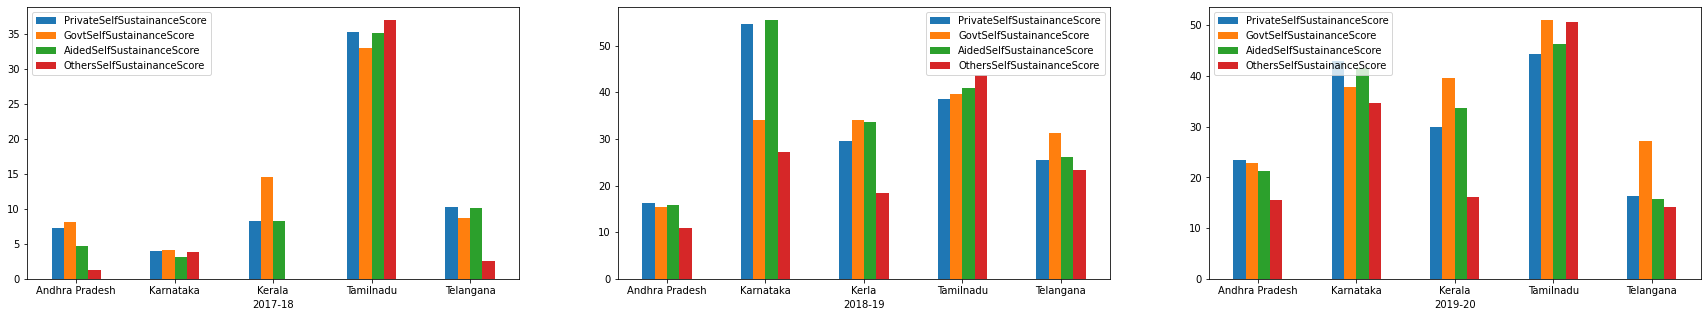

In [ ]:
#execution time 5min47s
fig1, axes1 = plt.subplots(1, 3, figsize=(30,5))

ans = {}
index = 0
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)
  ans[year] = private_govt_self_sustain_score_dist_Q2(SouthStates, data, axes1, index)
  index += 1

**Q5 : Investigate availability of Medical care**

a. Get the percentage of schools lacking medical check-up for south India

b. Get the percentage of schools having complete medical check-up for south India and segregate it based on rural, urban category

c. Plot the graph showing the state wise comparison  

Q5. a. Get the percentage of schools lacking medical check-up for south India.

2019_2020 :  [('Kerala', 16), ('Telangana', 13), ('Andhra Pradesh', 12), ('Karnataka', 7), ('Tamilnadu', 4)]


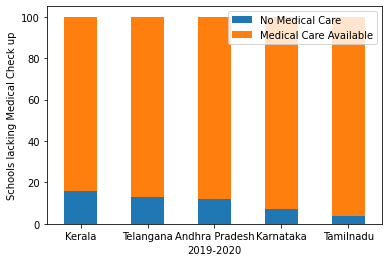

In [ ]:
#11s
dfs = []
for state in SouthStates:
  dfs.append(readAllDataForState(state, year))

data = unionAll(*dfs)
q5A, b = getSchoolsLackingMedical(SouthStates, data)
final = []
for i in q5A.collect():
  final.append(tuple(i))
print(year, ": ", final)
plot_SchoolsLackingMedical(SouthStates, data)

Q5. b. Get the percentage of schools having complete medical check-up for south India and segregate it based on rural, urban category

2019_2020 :  [('Rural', 64), ('Urban', 49)]


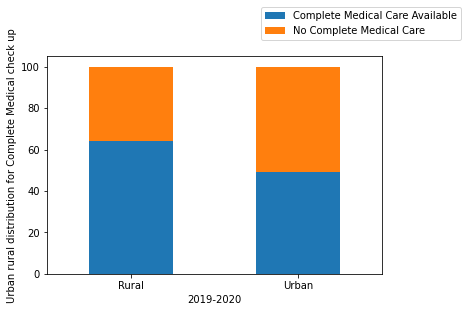

In [ ]:
#10s
dfs = []
for state in SouthStates:
  dfs.append(readAllDataForState(state, year))
data = unionAll(*dfs)
q5C, c = getUrbanRuralCompleteMedical(SouthStates, data)
final = []
for i in q5C.collect():
  final.append(tuple(i))
print(year, ": ", final)
plot_UrbanRuralCompleteMedical(SouthStates, data)

Q5. c. Plot the graph showing the state wise comparison

Text(0, 0.5, 'Availability of medical check up')

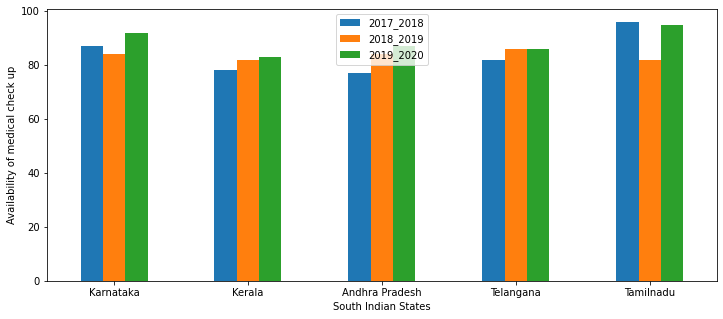

In [ ]:
#21s
index = 0
ans = {}
for year in years:
  data = {}
  for state in SouthStates:
    data[state] = readAllDataForState(state, year)

  allStatesData = [data[state] for state in SouthStates]
  allStatesData = unionAll(*allStatesData)
  ans[year], q1ADict = getSchoolsHavingMedical(SouthStates, allStatesData)
  index += 1

allYearsData = []
for year in years:
  currentYearData = ans[year]
  
  currentYearData = currentYearData.withColumnRenamed("Medical_Available_%", year).\
  withColumn("State_Name", regexp_replace('State_Name', 'Kerla', 'Kerala'))
  allYearsData.append(currentYearData)
temporalData = allYearsData[0].join(allYearsData[1], ["State_Name"]).join(allYearsData[2], ["State_Name"])
temporalDataPlot = temporalData.toPandas()
temporalDataPlot["2017_2018"]=pd.to_numeric(temporalDataPlot["2017_2018"])
temporalDataPlot["2018_2019"]=pd.to_numeric(temporalDataPlot["2018_2019"])
temporalDataPlot["2019_2020"]=pd.to_numeric(temporalDataPlot["2019_2020"])
ax = temporalDataPlot.plot.bar(x="State_Name", figsize=(12,5), rot=0)
ax.set_xlabel("South Indian States")
ax.set_ylabel("Availability of medical check up")

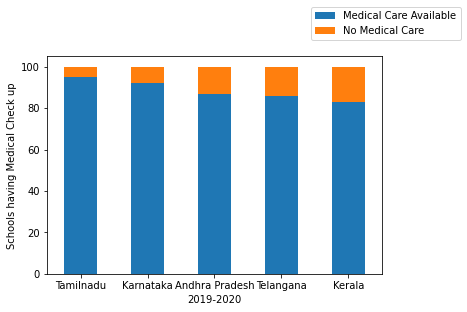

In [ ]:
#7s
dfs = []
for state in SouthStates:
  dfs.append(readAllDataForState(state, year))
data = unionAll(*dfs)
plot_SchoolsHavingMedical(SouthStates, data)

                                                                                END